# Iberdrola Project - Phase 2 [Occupancy Detection]

# Test GPU (Optional)
Before Starting, kindly check the available GPU from the Google Server, GPU model and other related information. It might help!

In [1]:
import torch
print("Is CUDA enabled GPU Available?", torch.cuda.is_available())
print("GPU Number:", torch.cuda.device_count())
print("Current GPU Index:", torch.cuda.current_device())
print("GPU Type:", torch.cuda.get_device_name(device=None))
print("GPU Capability:", torch.cuda.get_device_capability(device=None))
print("Is GPU Initialized yet?", torch.cuda.is_initialized())
print(torch.__version__)

Is CUDA enabled GPU Available? True
GPU Number: 1
Current GPU Index: 0
GPU Type: NVIDIA GeForce RTX 3080 Ti Laptop GPU
GPU Capability: (8, 6)
Is GPU Initialized yet? True
2.1.2+cu121


# Import Libraries

In [2]:
import os
import h5py
import scipy
import random
import pickle
import json
import configparser
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as sio
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.io import loadmat, savemat
from pathlib import Path
from tqdm import tqdm
from scipy import stats

In [3]:
%matplotlib inline
sns.set_style('white')

# Import and Prepare Data

## Prepare Dataset for Training

### Import and Extract Data

In [9]:
# Import
fl_Data = h5py.File(os.path.join('Raw_Data/Phase_2_Exp_2/H01_Data_Matched_Occupancy.mat'), 'r')
print(fl_Data.keys())
# Extract
X_Data = np.swapaxes(np.swapaxes(np.array(fl_Data['data_plugs']),0,1),1,2)
Y_Data = np.expand_dims(np.array(fl_Data['data_occupancy']), axis=2)
X_Data_shape = X_Data.shape
Y_Data_shape = Y_Data.shape
print(X_Data_shape)
print(Y_Data_shape)
sample_num = X_Data_shape[0]
segment_length = X_Data_shape[1]
num_channels = X_Data_shape[2]
# Check for NaNs and InFs
data = pd.Series(X_Data.ravel())
print(data.isna().any())
print(data.isin([np.inf, -np.inf]).any())
data = pd.Series(Y_Data.ravel())
print(data.isna().any())
print(data.isin([np.inf, -np.inf]).any())

<KeysViewHDF5 ['data_occupancy', 'data_plugs', 'data_sm']>
(85, 86400, 7)
(85, 86400, 1)
False
False
False
False


Plot Raw Segments

In [ ]:
segment_length = 86400
i = random.randint(0, X_Data_shape[0])
plt.figure(figsize=(32,21))
'''Fridge'''
plt.subplot(8,1,1)
plt.plot(X_Data[i,:,0], linewidth=3, label='Fridge GT', color='navy')
plt.title(f"House 01 - Fridge - Sample {i}", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Dryer'''
plt.subplot(8,1,2)
plt.plot(X_Data[i,:,1], linewidth=3, label='Dryer GT', color='navy')
plt.title(f"Dryer", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Kitchen Appliances'''
plt.subplot(8,1,3)
plt.plot(X_Data[i,:,2], linewidth=3, label='Kitchen Appliances GT', color='navy')
plt.title(f"Kitchen Appliances", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Kettle'''
plt.subplot(8,1,4)
plt.plot(X_Data[i,:,3], linewidth=3, label='Kettle GT', color='navy')
plt.title(f"Kettle", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Washing Machine'''
plt.subplot(8,1,5)
plt.plot(X_Data[i,:,4], linewidth=3, label='Washing Machine GT', color='navy')
plt.title(f"Washing Machine", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''PC and Router'''
plt.subplot(8,1,6)
plt.plot(X_Data[i,:,5], linewidth=3, label='PC and Router GT', color='navy')
plt.title(f"PC and Router", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Freezer'''
plt.subplot(8,1,7)
plt.plot(X_Data[i,:,6], linewidth=3, label='Freezer GT', color='navy')
plt.title(f"Freezer", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Occupancy Label'''
plt.subplot(8,1,8)
plt.plot(Y_Data[i,:,0], linewidth=3, label='Occupancy Label GT', color='navy')
plt.title(f"Occupancy Label", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

### Data Pruning V1

Select channels with an acceptable number of datapoints (optional, for only multichannel)

In [10]:
thresh = 0.05
X_Data_Pruned = np.zeros((sample_num,segment_length,num_channels))
device_list = ['Fridge','Dryer','Kitchen_Appliances','Kettle','Washing_Machine','PC_Router','Freezer']
counter = 0
for i in range(0,num_channels):
    data_current_channel = X_Data[:,:,i]
    data_current_channel_corr, _ = stats.pearsonr(data_current_channel.ravel(), Y_Data.ravel())
    # data_current_channel_var = np.var(data_current_channel.ravel())
    if (data_current_channel_corr < thresh) or (i == 0) or (i == 6):
        print(device_list[i])
        print(data_current_channel_corr)
        continue
    else:
        X_Data_Pruned[:,:,counter] = data_current_channel
        counter = counter + 1
X_Data_Pruned = X_Data_Pruned[:,:,0:counter]
X_Data_Shape = X_Data_Pruned.shape
num_channels = X_Data_Shape[2]
print(X_Data_Pruned.shape)
print(Y_Data.shape)

Fridge
0.040178389070465656
Kitchen_Appliances
0.019218576526886712
Kettle
0.025938499841541462
Washing_Machine
0.0385387946553126
PC_Router
0.04754562136979382
Freezer
0.0033314137502733487
(85, 86400, 1)
(85, 86400, 1)


Transform Data

In [11]:
X_Data_Shape = X_Data_Pruned.shape
sample_num = X_Data_Shape[0]
segment_length = X_Data_Shape[1]
num_channels = X_Data_Shape[2]
X_Data_New = np.zeros((sample_num,segment_length,num_channels))
# Step 1: Range Normalize Data based on [0 1] threshold
counter = 0
threshold1 = 0
for i in range(0,sample_num):
    X_Data_Temp = X_Data_Pruned[i,:,:]
    for ii in range(0,num_channels):
        X_Data_Temp_Ch = X_Data_Temp[:,ii]
        for iii in range(0,segment_length):
            X_Data_Temp_Ch_Point = X_Data_Temp_Ch[iii]
            if X_Data_Temp_Ch_Point > threshold1:
                X_Data_Temp_Ch_Point = 1
            X_Data_New[counter,iii,ii] = X_Data_Temp_Ch_Point
    counter = counter + 1
X_Data_New = np.int_(X_Data_New[0:counter,:,:])
print(X_Data_New.shape)
print(Y_Data.shape)
print(np.unique(X_Data_New))

(85, 86400, 1)
(85, 86400, 1)
[0 1]


In [12]:
# Step 2: Merge short pulses into longer one based on threshold duration
X_Data_Shape = X_Data_New.shape
sample_num = X_Data_Shape[0]
segment_length = X_Data_Shape[1]
num_channels = X_Data_Shape[2]
counter = 0
threshold2 = 3600
for i in range(0,sample_num):
    X_Data_Temp = X_Data_New[i,:,:]
    for ii in range(0,num_channels):
        X_Data_Temp_Ch = X_Data_Temp[:,ii]
        if np.var(X_Data_Temp_Ch) > 0:
            transition_points = []
            for iii in range(1,segment_length):
                X_Data_Temp_Ch_Previous_Point = X_Data_Temp_Ch[iii-1]
                X_Data_Temp_Ch_Current_Point = X_Data_Temp_Ch[iii]
                if X_Data_Temp_Ch_Previous_Point != X_Data_Temp_Ch_Current_Point:
                    transition_points.append(iii)
            # print(transition_points)
            for iii in range(1,len(transition_points)):
                if ((transition_points[iii-1]-300) >= 0) and ((transition_points[iii-1]+300) < segment_length):
                    X_Data_Temp_Ch[transition_points[iii-1]-300:transition_points[iii-1]+300] = 1
                elif ((transition_points[iii-1]-300) < 0) and ((transition_points[iii-1]+300) < segment_length):
                    X_Data_Temp_Ch[0:transition_points[iii-1]+300] = 1
                elif ((transition_points[iii-1]-300) >= 0) and ((transition_points[iii-1]+300) >= segment_length):
                    X_Data_Temp_Ch[transition_points[iii-1]-300:segment_length] = 1
                transition_interval = transition_points[iii] - transition_points[iii-1]
                if transition_interval <= threshold2:
                    X_Data_Temp_Ch[transition_points[iii-1]:transition_points[iii]] = 1
        X_Data_New[counter,:,ii] = X_Data_Temp_Ch
    counter = counter + 1
X_Data_New = X_Data_New[0:counter,:,:]
print(X_Data_New.shape)
print(Y_Data.shape)

(85, 86400, 1)
(85, 86400, 1)


Plot again

In [ ]:
segment_length = 86400
i = random.randint(0, X_Data_shape[0])
plt.figure(figsize=(32,16))
'''Dryer'''
plt.subplot(6,1,1)
plt.plot(X_Data_New[i,:,0], linewidth=3, label='Dryer GT', color='navy')
plt.plot(X_Data[i,:,1], linewidth=3, label='Dryer GT', color='red')
plt.title(f"House 01 - Dryer - Sample {i}", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Kitchen Appliances'''
plt.subplot(6,1,2)
plt.plot(X_Data_New[i,:,1], linewidth=3, label='Kitchen Appliances GT', color='navy')
plt.plot(X_Data[i,:,2], linewidth=3, label='Kitchen Appliances GT', color='red')
plt.title(f"Kitchen Appliances", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Kettle'''
plt.subplot(6,1,3)
plt.plot(X_Data_New[i,:,2], linewidth=3, label='Kettle GT', color='navy')
plt.plot(X_Data[i,:,3], linewidth=3, label='Kettle GT', color='red')
plt.title(f"Kettle", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Washing Machine'''
plt.subplot(6,1,4)
plt.plot(X_Data_New[i,:,3], linewidth=3, label='Washing Machine GT', color='navy')
plt.plot(X_Data[i,:,4], linewidth=3, label='Washing Machine GT', color='red')
plt.title(f"Washing Machine", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''PC and Router'''
plt.subplot(6,1,5)
plt.plot(X_Data_New[i,:,4], linewidth=3, label='PC and Router GT', color='navy')
plt.plot(X_Data[i,:,5], linewidth=3, label='PC and Router GT', color='red')
plt.title(f"PC and Router", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Occupancy Label'''
plt.subplot(6,1,6)
plt.plot(Y_Data[i,:,0], linewidth=3, label='Occupancy Label GT', color='navy')
plt.title(f"Occupancy Label", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

In [13]:
X_Data_Shape = X_Data_New.shape
Y_Data_Shape = Y_Data.shape
sample_num = X_Data_Shape[0]
segment_length = X_Data_Shape[1]
num_channels = X_Data_Shape[2]
X_Data_AGG = np.zeros((sample_num,segment_length,1))
counter = 0
for i in range(0,sample_num):
    X_Data_Temp = X_Data_New[i,:,:]
    X_Data_Temp = np.sum(X_Data_Temp, axis=1)
    X_Data_Temp[X_Data_Temp > 0] = 1
    X_Data_AGG[counter,:,0] = X_Data_Temp
    counter = counter + 1
X_Data_AGG = np.int_(X_Data_AGG[0:counter,:,:])
print(X_Data_AGG.shape)
print(Y_Data.shape)
print(np.unique(X_Data_AGG))
print(np.unique(Y_Data))

(85, 86400, 1)
(85, 86400, 1)
[0 1]
[0. 1.]


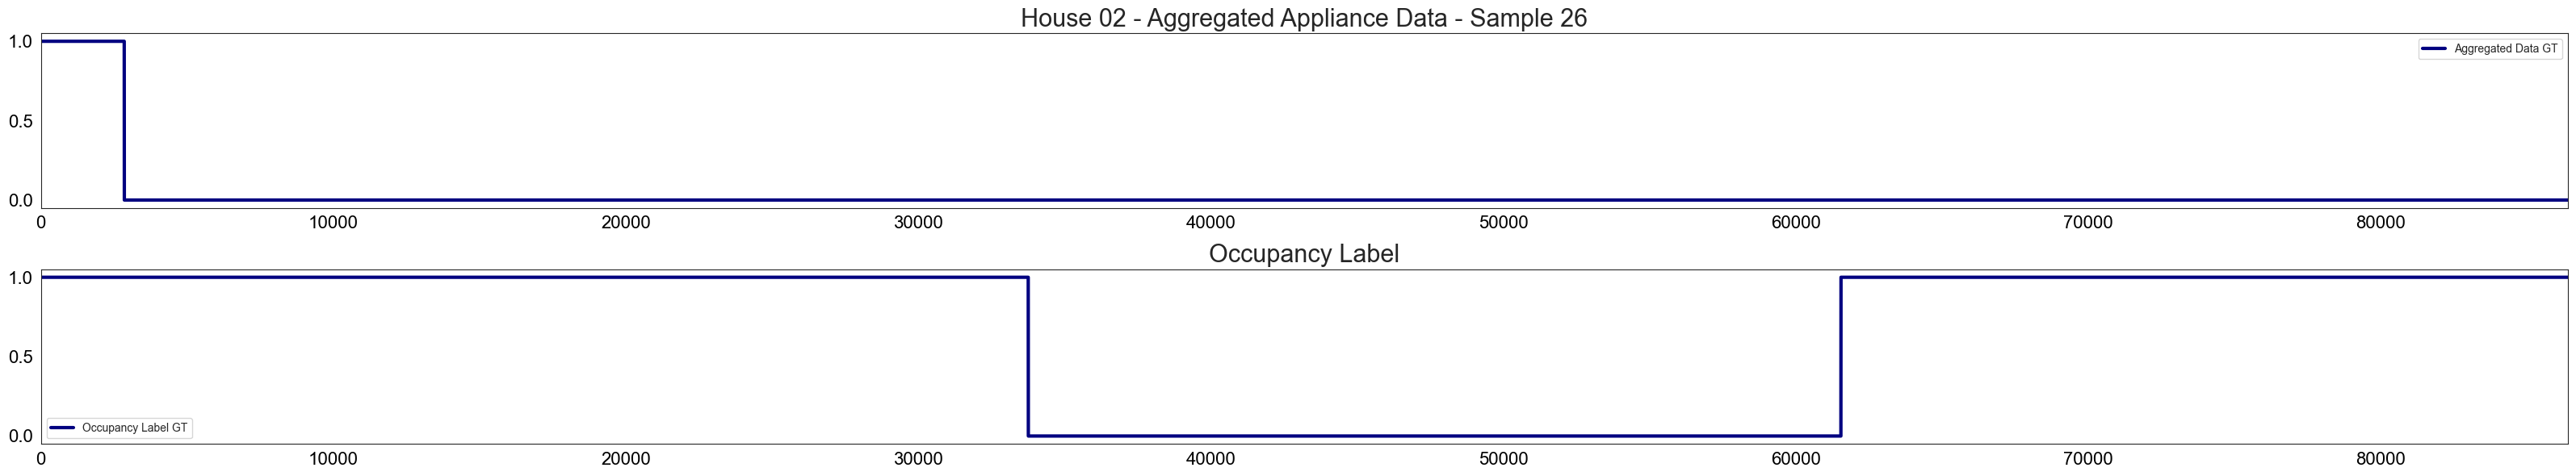

In [14]:
segment_length = 86400
i = random.randint(0, X_Data_AGG.shape[0]-1)
'''Dishwasher'''
plt.figure(figsize=(32,6))
plt.subplot(2,1,1)
plt.plot(X_Data_AGG[i,:,0], linewidth=3, label='Aggregated Data GT', color='navy')
plt.title(f"House 02 - Aggregated Appliance Data - Sample {i}", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
'''Occupancy Label'''
plt.subplot(2,1,2)
plt.plot(Y_Data[i,:,0], linewidth=3, label='Occupancy Label GT', color='navy')
plt.title(f"Occupancy Label", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

### Data Pruning V2

In [15]:
thresh = 0.001
X_Data_Pruned = np.zeros((sample_num,segment_length,num_channels))
device_list = ['Fridge','Dryer','Kitchen_Appliances','Kettle','Washing_Machine','PC_Router','Freezer']
counter = 0
for i in range(0,num_channels):
    data_current_channel = X_Data[:,:,i]
    data_current_channel_corr, _ = stats.pearsonr(data_current_channel.ravel(), Y_Data.ravel())
    # data_current_channel_var = np.var(data_current_channel.ravel())
    if (data_current_channel_corr < thresh) or (i == 0) or (i == 6):
        print(device_list[i])
        print(data_current_channel_corr)
        continue
    else:
        X_Data_Pruned[:,:,counter] = data_current_channel
        counter = counter + 1
X_Data_Pruned = X_Data_Pruned[:,:,0:counter]
X_Data_Shape = X_Data_Pruned.shape
num_channels = X_Data_Shape[2]
print(X_Data_Pruned.shape)
print(Y_Data.shape)

Fridge
0.040178389070465656
Freezer
0.0033314137502733487
(85, 86400, 5)
(85, 86400, 1)


In [16]:
X_Data_Shape = X_Data_Pruned.shape
Y_Data_Shape = Y_Data.shape
sample_num = X_Data_Shape[0]
segment_length = X_Data_Shape[1]
num_channels = X_Data_Shape[2]
X_Data_AGG = np.zeros((sample_num,segment_length,1))
counter = 0
for i in range(0,sample_num):
    X_Data_Temp = X_Data_Pruned[i,:,:]
    X_Data_Temp = np.sum(X_Data_Temp, axis=1)
    if np.var(X_Data_Temp) > 0:
        X_Data_Temp = (X_Data_Temp - np.min(X_Data_Temp))/(np.max(X_Data_Temp) - np.min(X_Data_Temp))
    X_Data_AGG[counter,:,0] = X_Data_Temp
    counter = counter + 1
X_Data_AGG = X_Data_AGG[0:counter,:,:]
print(X_Data_AGG.shape)
print(Y_Data.shape)
print(np.unique(X_Data_AGG))

(85, 86400, 1)
(85, 86400, 1)
[0.         0.01095255 0.01105886 ... 0.99953608 1.         1.        ]


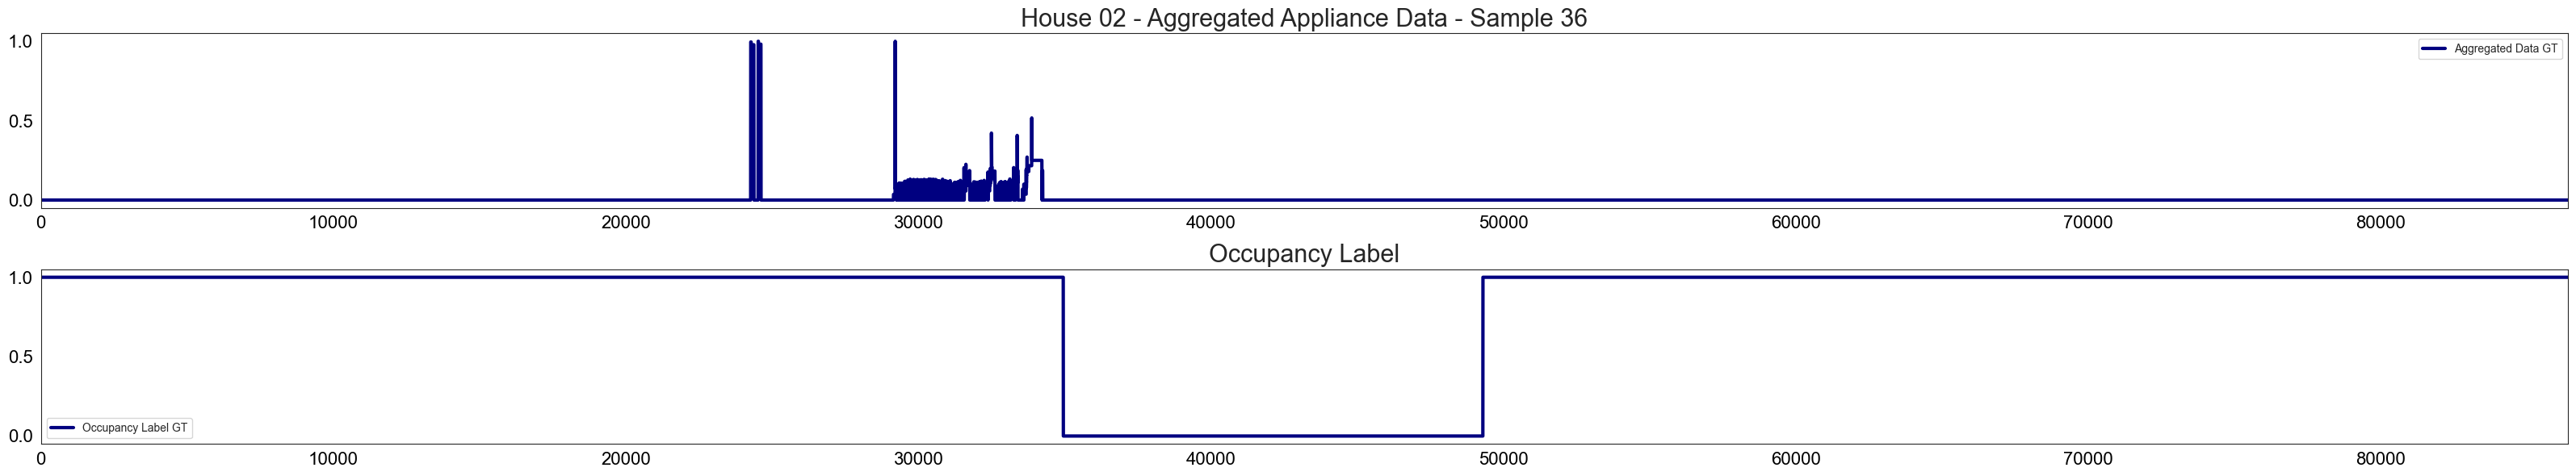

In [17]:
segment_length = 86400
i = random.randint(0, X_Data_AGG.shape[0]-1)
'''Dishwasher'''
plt.figure(figsize=(32,6))
plt.subplot(2,1,1)
plt.plot(X_Data_AGG[i,:,0], linewidth=3, label='Aggregated Data GT', color='navy')
plt.title(f"House 02 - Aggregated Appliance Data - Sample {i}", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
'''Occupancy Label'''
plt.subplot(2,1,2)
plt.plot(Y_Data[i,:,0], linewidth=3, label='Occupancy Label GT', color='navy')
plt.title(f"Occupancy Label", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

### Data Pruning V3

In [43]:
thresh = 0.001
X_Data_Pruned = np.zeros((sample_num,segment_length,num_channels))
device_list = ['Fridge','Dryer','Kitchen_Appliances','Kettle','Washing_Machine','PC_Router','Freezer']
counter = 0
for i in range(0,num_channels):
    data_current_channel = X_Data[:,:,i]
    data_current_channel_corr, _ = stats.pearsonr(data_current_channel.ravel(), Y_Data.ravel())
    # data_current_channel_var = np.var(data_current_channel.ravel())
    if (data_current_channel_corr < thresh) or (i == 0) or (i == 6):
        print(device_list[i])
        print(data_current_channel_corr)
        continue
    else:
        X_Data_Pruned[:,:,counter] = data_current_channel
        counter = counter + 1
X_Data_Pruned = X_Data_Pruned[:,:,0:counter]
X_Data_Shape = X_Data_Pruned.shape
num_channels = X_Data_Shape[2]
print(X_Data_Pruned.shape)
print(Y_Data.shape)

Fridge
0.040178389070465656
Freezer
0.0033314137502733487
(85, 86400, 5)
(85, 86400, 1)


In [44]:
X_Data_Shape = X_Data_Pruned.shape
sample_num = X_Data_Shape[0]
segment_length = X_Data_Shape[1]
num_channels = X_Data_Shape[2]
X_Data_New = np.zeros((sample_num,segment_length,num_channels))
# Step 1: Range Normalize Data based on [0 1] threshold
counter = 0
threshold1 = 0
for i in range(0,sample_num):
    X_Data_Temp = X_Data_Pruned[i,:,:]
    for ii in range(0,num_channels):
        X_Data_Temp_Ch = X_Data_Temp[:,ii]
        for iii in range(0,segment_length):
            X_Data_Temp_Ch_Point = X_Data_Temp_Ch[iii]
            if X_Data_Temp_Ch_Point > threshold1:
                X_Data_Temp_Ch_Point = 1
            X_Data_New[counter,iii,ii] = X_Data_Temp_Ch_Point
    counter = counter + 1
X_Data_New = np.int_(X_Data_New[0:counter,:,:])
print(X_Data_New.shape)
print(Y_Data.shape)
print(np.unique(X_Data_New))

(85, 86400, 5)
(85, 86400, 1)
[0 1]


In [45]:
# Step 2: Merge short pulses into longer one based on threshold duration
X_Data_Shape = X_Data_New.shape
sample_num = X_Data_Shape[0]
segment_length = X_Data_Shape[1]
num_channels = X_Data_Shape[2]
counter = 0
threshold2 = 3600
for i in range(0,sample_num):
    X_Data_Temp = X_Data_New[i,:,:]
    for ii in range(0,num_channels):
        X_Data_Temp_Ch = X_Data_Temp[:,ii]
        if np.var(X_Data_Temp_Ch) > 0:
            transition_points = []
            for iii in range(1,segment_length):
                X_Data_Temp_Ch_Previous_Point = X_Data_Temp_Ch[iii-1]
                X_Data_Temp_Ch_Current_Point = X_Data_Temp_Ch[iii]
                if X_Data_Temp_Ch_Previous_Point != X_Data_Temp_Ch_Current_Point:
                    transition_points.append(iii)
            # print(transition_points)
            for iii in range(1,len(transition_points)):
                if ((transition_points[iii-1]-300) >= 0) and ((transition_points[iii-1]+300) < segment_length):
                    X_Data_Temp_Ch[transition_points[iii-1]-300:transition_points[iii-1]+300] = 1
                elif ((transition_points[iii-1]-300) < 0) and ((transition_points[iii-1]+300) < segment_length):
                    X_Data_Temp_Ch[0:transition_points[iii-1]+300] = 1
                elif ((transition_points[iii-1]-300) >= 0) and ((transition_points[iii-1]+300) >= segment_length):
                    X_Data_Temp_Ch[transition_points[iii-1]-300:segment_length] = 1
                transition_interval = transition_points[iii] - transition_points[iii-1]
                if transition_interval <= threshold2:
                    X_Data_Temp_Ch[transition_points[iii-1]:transition_points[iii]] = 1
        X_Data_New[counter,:,ii] = X_Data_Temp_Ch
    counter = counter + 1
X_Data_New = X_Data_New[0:counter,:,:]
print(X_Data_New.shape)
print(Y_Data.shape)

(85, 86400, 5)
(85, 86400, 1)


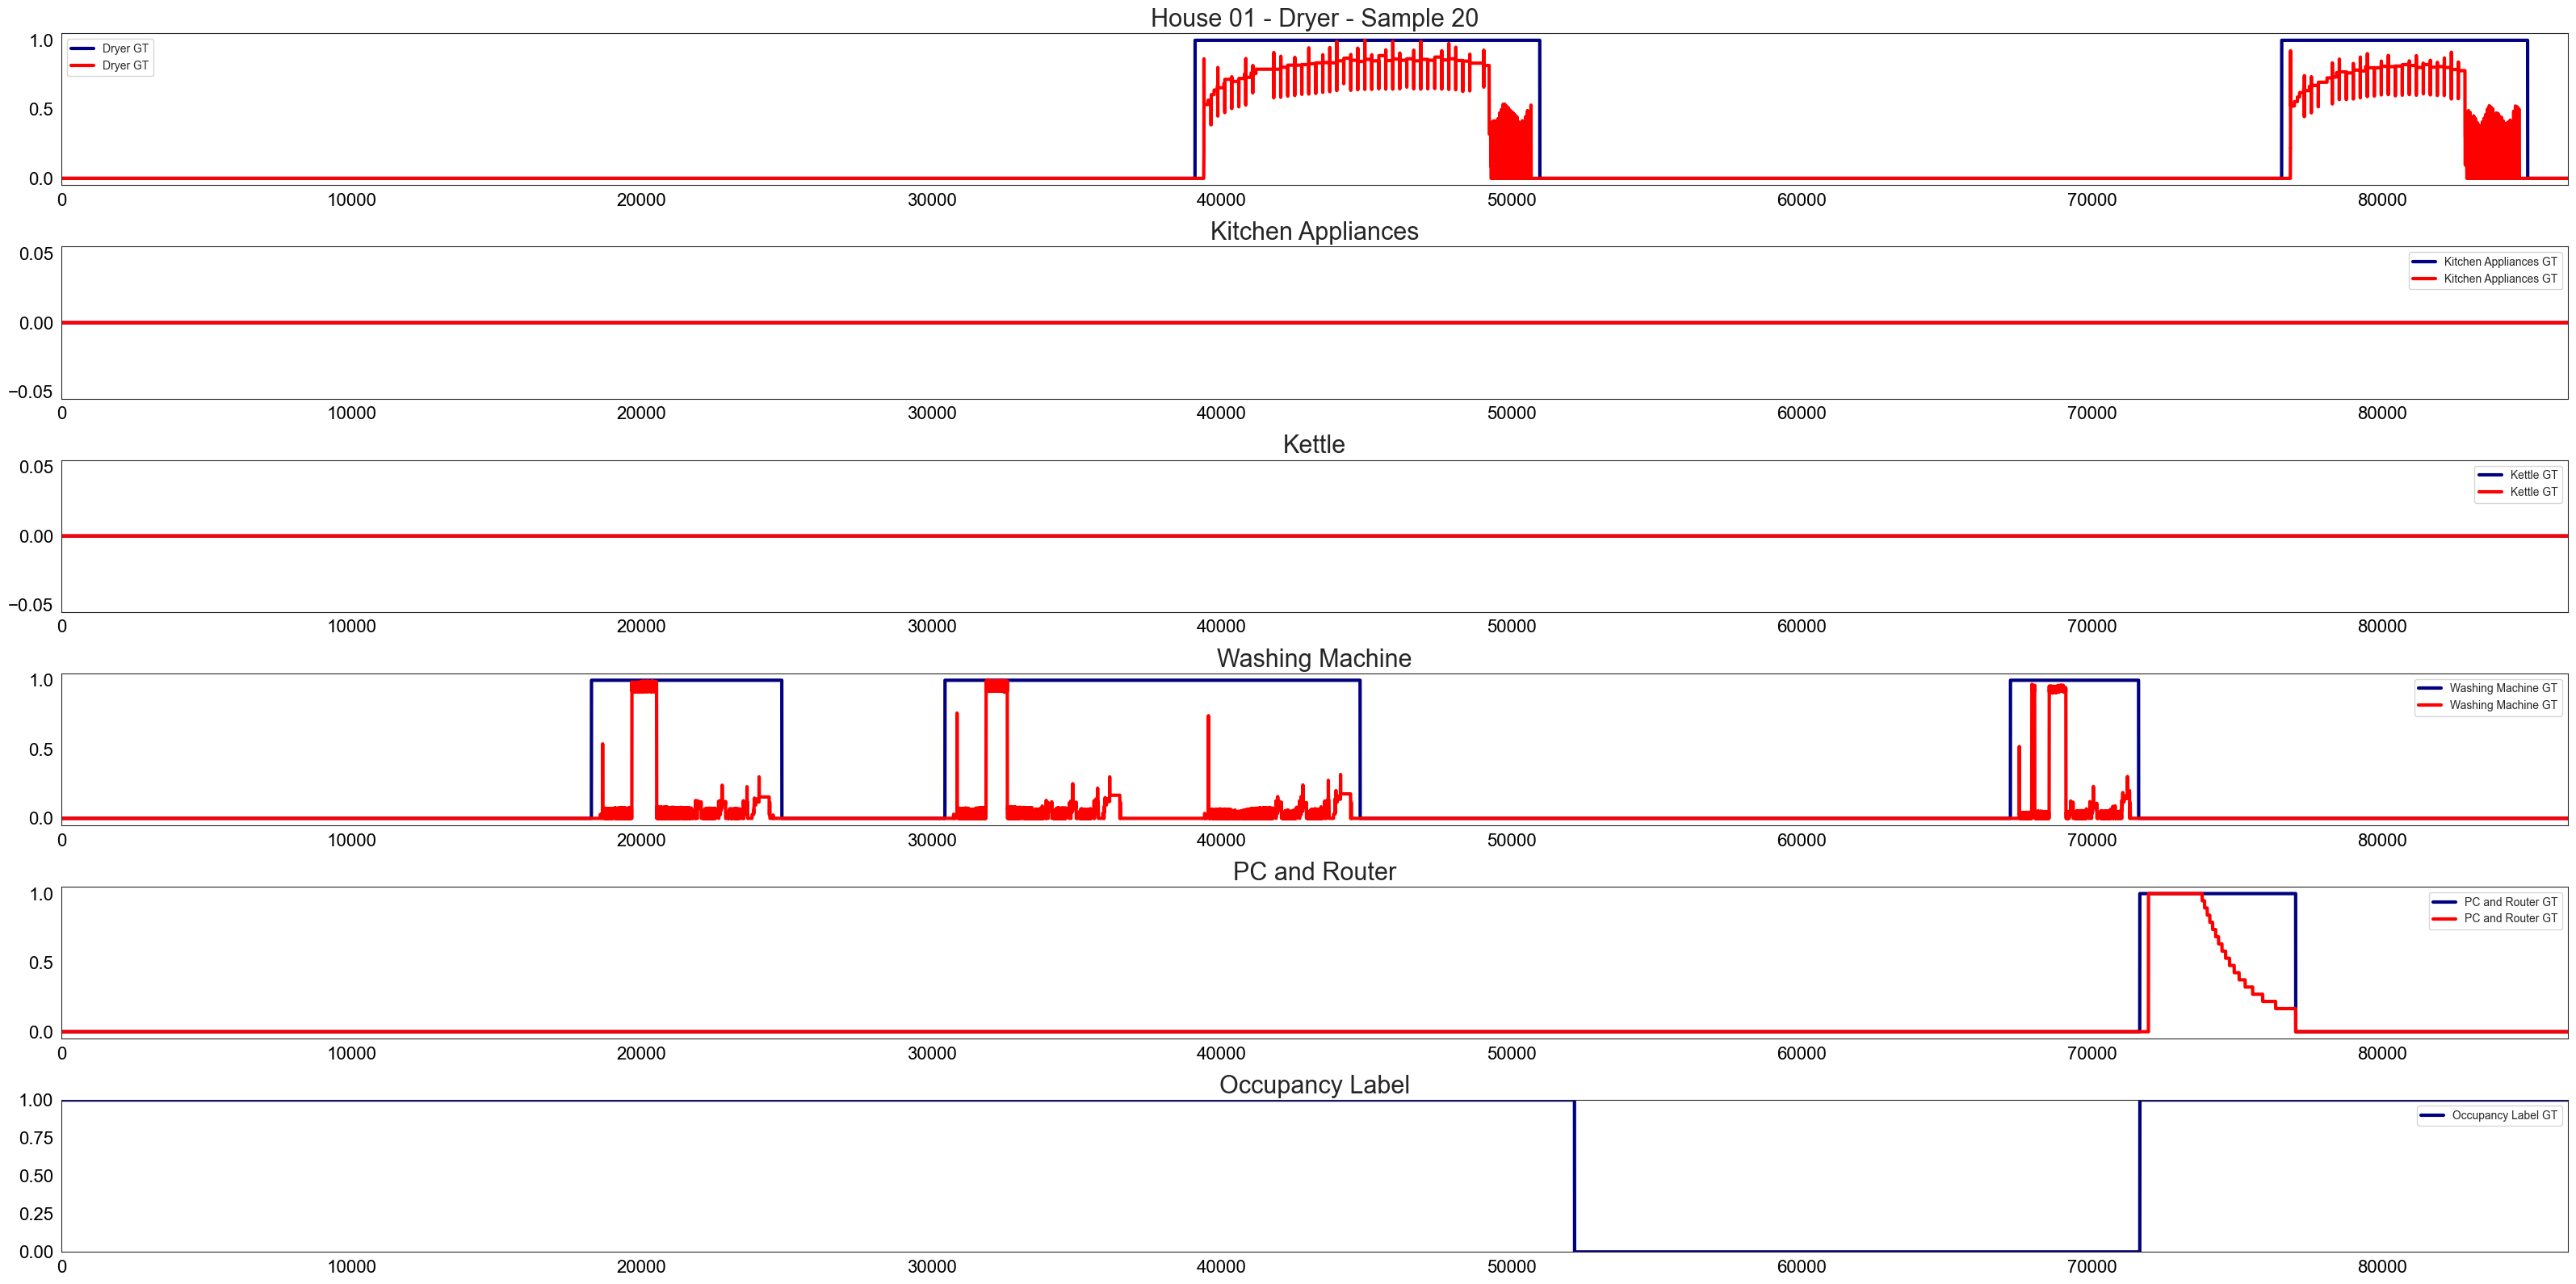

In [51]:
segment_length = 86400
i = random.randint(0, X_Data_shape[0])
plt.figure(figsize=(32,16))
'''Dryer'''
plt.subplot(6,1,1)
plt.plot(X_Data_New[i,:,0], linewidth=3, label='Dryer GT', color='navy')
plt.plot(X_Data[i,:,1], linewidth=3, label='Dryer GT', color='red')
plt.title(f"House 01 - Dryer - Sample {i}", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Kitchen Appliances'''
plt.subplot(6,1,2)
plt.plot(X_Data_New[i,:,1], linewidth=3, label='Kitchen Appliances GT', color='navy')
plt.plot(X_Data[i,:,2], linewidth=3, label='Kitchen Appliances GT', color='red')
plt.title(f"Kitchen Appliances", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Kettle'''
plt.subplot(6,1,3)
plt.plot(X_Data_New[i,:,2], linewidth=3, label='Kettle GT', color='navy')
plt.plot(X_Data[i,:,3], linewidth=3, label='Kettle GT', color='red')
plt.title(f"Kettle", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Washing Machine'''
plt.subplot(6,1,4)
plt.plot(X_Data_New[i,:,3], linewidth=3, label='Washing Machine GT', color='navy')
plt.plot(X_Data[i,:,4], linewidth=3, label='Washing Machine GT', color='red')
plt.title(f"Washing Machine", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''PC and Router'''
plt.subplot(6,1,5)
plt.plot(X_Data_New[i,:,4], linewidth=3, label='PC and Router GT', color='navy')
plt.plot(X_Data[i,:,5], linewidth=3, label='PC and Router GT', color='red')
plt.title(f"PC and Router", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Occupancy Label'''
plt.subplot(6,1,6)
plt.plot(Y_Data[i,:,0], linewidth=3, label='Occupancy Label GT', color='navy')
plt.title(f"Occupancy Label", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

In [70]:
X_Data_Shape = X_Data_New.shape
Y_Data_Shape = Y_Data.shape
sample_num = X_Data_Shape[0]
segment_length = X_Data_Shape[1]
num_channels = X_Data_Shape[2]
X_Data_AGG = np.zeros((sample_num,segment_length,1))
counter = 0
for i in range(0,sample_num):
    X_Data_Temp = X_Data_New[i,:,:]
    X_Data_Temp = np.sum(X_Data_Temp, axis=1)
    if np.var(X_Data_Temp) > 0:
        X_Data_Temp = (X_Data_Temp - np.min(X_Data_Temp))/(np.max(X_Data_Temp) - np.min(X_Data_Temp))
    X_Data_AGG[counter,:,0] = X_Data_Temp
    counter = counter + 1
X_Data_AGG = X_Data_AGG[0:counter,:,:]
print(X_Data_AGG.shape)
print(Y_Data.shape)
print(np.unique(X_Data_AGG))

(85, 86400, 1)
(85, 86400, 1)
[0.         0.33333333 0.5        0.66666667 1.        ]


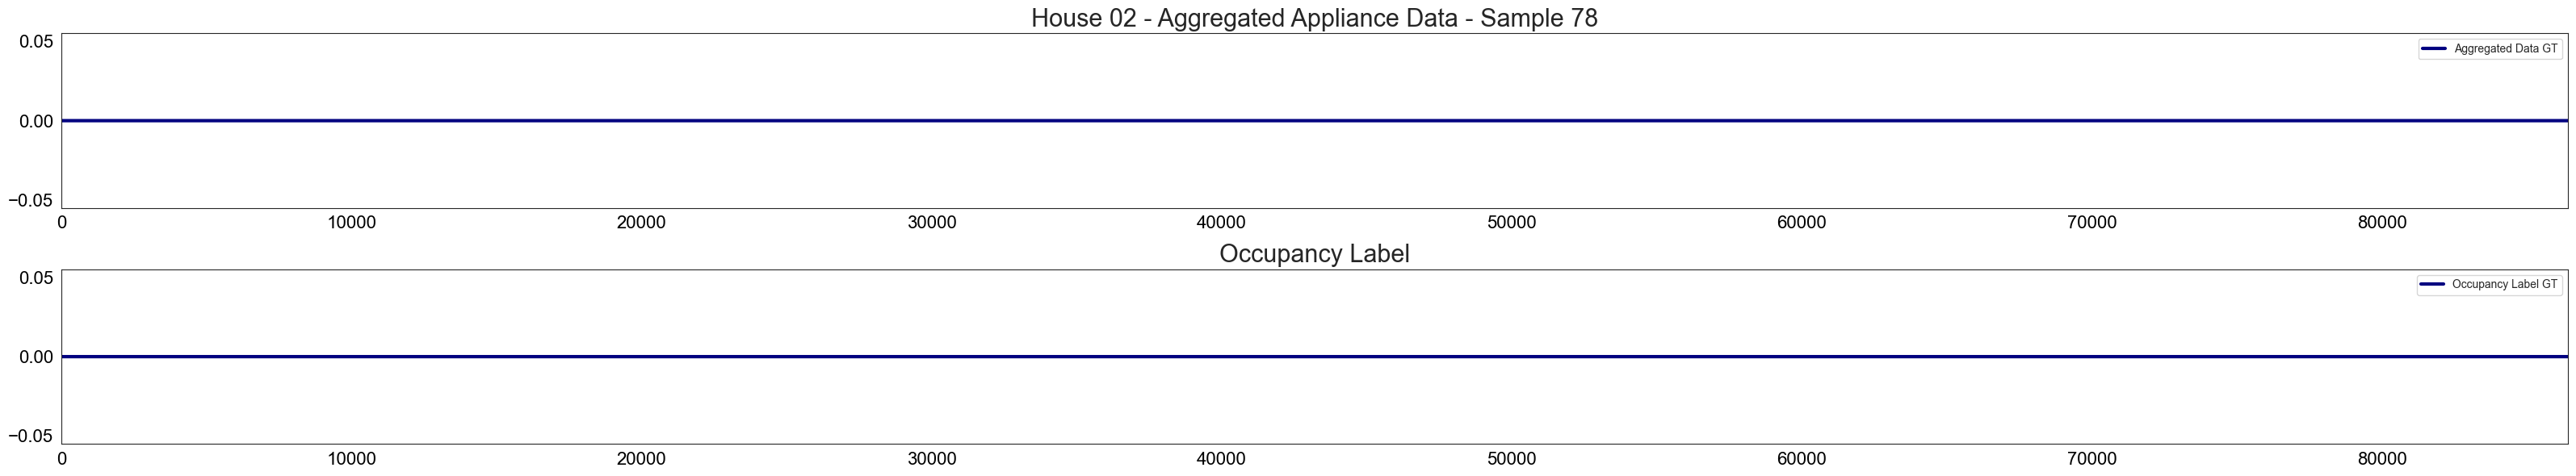

In [89]:
segment_length = 86400
i = random.randint(0, X_Data_AGG.shape[0]-1)
'''Dishwasher'''
plt.figure(figsize=(32,6))
plt.subplot(2,1,1)
plt.plot(X_Data_AGG[i,:,0], linewidth=3, label='Aggregated Data GT', color='navy')
plt.title(f"House 02 - Aggregated Appliance Data - Sample {i}", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
'''Occupancy Label'''
plt.subplot(2,1,2)
plt.plot(Y_Data[i,:,0], linewidth=3, label='Occupancy Label GT', color='navy')
plt.title(f"Occupancy Label", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

### Cleanse and Save House 01 data for the combined approach

In [15]:
# Curate
X_Data_Shape = X_Data_AGG.shape
Y_Data_Shape = Y_Data.shape
sample_num = X_Data_Shape[0]
segment_length = X_Data_Shape[1]
num_channels = X_Data_Shape[2]
X_Data_Curated = np.zeros((sample_num,segment_length,num_channels))
Y_Data_Curated = np.zeros((sample_num,segment_length,1))
counter = 0
for i in range(0,sample_num):
    X_Data_Temp = X_Data_AGG[i,:,:]
    Y_Data_Temp = Y_Data[i,:,:]
    Y_Data_Temp_SUM = np.sum(Y_Data_Temp)
    if (Y_Data_Temp_SUM < np.round(0.01*segment_length)) or (Y_Data_Temp_SUM > np.round(0.99*segment_length)):
        continue
    if (np.var(X_Data_Temp) > 0.0001):
        X_Data_Curated[counter,:,:] = X_Data_Temp
        Y_Data_Curated[counter,:,:] = Y_Data_Temp
        counter = counter + 1
X_Data_Curated = np.int_(X_Data_Curated[0:counter,:,:])
Y_Data_Curated = np.int_(Y_Data_Curated[0:counter,:,:])
print(X_Data_Curated.shape)
print(Y_Data_Curated.shape)
print(np.unique(X_Data_Curated))
print(np.unique(Y_Data_Curated))
# Save
data_dic = {"X_Data": X_Data_Curated,
            "Y_Data": Y_Data_Curated,
            }
savemat("Occupancy_Data_Curated_House_01_V2.mat", data_dic, format='5')

(15, 86400, 1)
(15, 86400, 1)
[0 1]
[0 1]


### Create Folds - Train and Test Sets - 20% for Test - 10% for Validation

In [14]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X_Data_AGG, Y_Data, test_size=0.2, random_state=0)
X_Val = X_Test
Y_Val = Y_Test
print(X_Train.shape)
print(Y_Train.shape)
print(X_Test.shape)
print(Y_Test.shape)
print(X_Val.shape)
print(Y_Val.shape)

(68, 86400, 1)
(68, 86400, 1)
(17, 86400, 1)
(17, 86400, 1)
(17, 86400, 1)
(17, 86400, 1)


### Overlap Train Set

In [15]:
# Overlap
X_Data_Shape = X_Train.shape
Y_Data_Shape = Y_Train.shape
segment_length = X_Data_Shape[1]
num_channels = X_Data_Shape[2]
print(X_Data_Shape)
print(Y_Data_Shape)
# Reshape Array
X_Data_Reshaped = np.reshape(X_Train, (X_Data_Shape[0]*X_Data_Shape[1], num_channels))
Y_Data_Reshaped = np.reshape(Y_Train, (Y_Data_Shape[0]*Y_Data_Shape[1], 1))
X_Data_Reshaped_Shape = X_Data_Reshaped.shape
Y_Data_Reshaped_Shape = Y_Data_Reshaped.shape
print(X_Data_Reshaped_Shape)
print(Y_Data_Reshaped_Shape)
# Overlap
overlap_ratio = 0.9
offset_amount = np.int_(segment_length*(1 - overlap_ratio))
X_Data_New = np.zeros((2000,segment_length,num_channels))
Y_Data_New = np.zeros((2000,segment_length,1))
num_segments_approx = np.int_(np.ceil(X_Data_Reshaped_Shape[0]/offset_amount))
counter = 0
for i in range(0,num_segments_approx):
    if (i*offset_amount+segment_length) > X_Data_Reshaped_Shape[0]:
        continue
    X_Data_Temp = X_Data_Reshaped[i*offset_amount:i*offset_amount+segment_length,:]
    X_Data_New[counter,:,:] = X_Data_Temp
    Y_Data_Temp = Y_Data_Reshaped[i*offset_amount:i*offset_amount+segment_length,:]
    Y_Data_New[counter,:,:] = Y_Data_Temp
    counter = counter + 1
X_Train_OVRL = X_Data_New[0:counter,:,:]
Y_Train_OVRL = Y_Data_New[0:counter,:,:]
print(X_Train_OVRL.shape)
print(Y_Train_OVRL.shape)

(68, 86400, 1)
(68, 86400, 1)
(5875200, 1)
(5875200, 1)
(671, 86400, 1)
(671, 86400, 1)


### Transform Labels for Classification

In [16]:
def transform_labels(X_Data_OVRL, Y_Data_OVRL, segment_length, num_channels):
    X_Data_New = np.zeros((20000,num_channels,segment_length))
    Y_Data_New = np.zeros((20000,1), dtype=int)
    ## Raw Dataset
    X_Data_Shape = X_Data_OVRL.shape
    Y_Data_Shape = Y_Data_OVRL.shape
    # Reshape Array
    X_Data_Reshaped = np.reshape(X_Data_OVRL, (X_Data_Shape[0]*X_Data_Shape[1], num_channels))
    Y_Data_Reshaped = np.reshape(Y_Data_OVRL, (Y_Data_Shape[0]*Y_Data_Shape[1], 1))
    X_Data_Reshaped_Shape = X_Data_Reshaped.shape
    Y_Data_Reshaped_Shape = Y_Data_Reshaped.shape
    num_segments_approx = np.int_(np.ceil(X_Data_Reshaped_Shape[0]/segment_length))
    counter = 0
    for i in range(0,num_segments_approx):
        if ((i+1)*segment_length) > X_Data_Reshaped_Shape[0]:
            continue
        X_Data_Temp = np.transpose(X_Data_Reshaped[i*segment_length:(i+1)*segment_length,:])
        X_Data_Temp_Mean = np.mean(X_Data_Temp)
        X_Data_Temp_VAR = np.var(X_Data_Temp)
        X_Data_New[counter,:,:] = X_Data_Temp
        Y_Data_Temp = Y_Data_Reshaped[i*segment_length:(i+1)*segment_length,:]
        Y_Data_Temp_Mean = np.mean(Y_Data_Temp)
        Y_Data_Temp_VAR = np.var(Y_Data_Temp)
        Y_Data_Temp_SUM = np.sum(Y_Data_Temp)
        if X_Data_Temp_VAR <= 0.0001:
            continue
        # if Y_Data_Temp_VAR <= 0.001:
            # continue
        if (Y_Data_Temp_SUM < np.round(0.1*segment_length)) or (Y_Data_Temp_SUM > np.round(0.90*segment_length)):
            continue
        # if Y_Data_Temp_SUM == segment_length:
            # continue
        if Y_Data_Temp_Mean > 0.5:
            Y_Label = 1
        else:
            Y_Label = 0
        Y_Data_New[counter,:] = Y_Label
        counter = counter + 1
    X_Data_New = X_Data_New[0:counter,:,:]
    Y_Data_New = Y_Data_New[0:counter,:]
    return X_Data_New, Y_Data_New

In [17]:
segment_length = 1200  # 20 Minutes = 1200 Data Points (1 Hz sampling rate)
X_Train_C, Y_Train_C = transform_labels(X_Train_OVRL, Y_Train_OVRL, segment_length, num_channels)
X_Test_C, Y_Test_C = transform_labels(X_Test, Y_Test, segment_length, num_channels)
X_Val_C, Y_Val_C = transform_labels(X_Test, Y_Test, segment_length, num_channels)
print(X_Train_C.shape)
print(Y_Train_C.shape)
print(X_Test_C.shape)
print(Y_Test_C.shape)
print(X_Val_C.shape)
print(Y_Val_C.shape)
labels, counts = np.unique(Y_Train_C, return_counts=True)
print(labels, counts)
labels, counts = np.unique(Y_Test_C, return_counts=True)
print(labels, counts)
labels, counts = np.unique(Y_Val_C, return_counts=True)
print(labels, counts)


(96, 1, 1200)
(96, 1)
(2, 1, 1200)
(2, 1)
(2, 1, 1200)
(2, 1)
[0 1] [40 56]
[1] [2]
[1] [2]


### Balance train set (if required)

In [11]:
Y_Train_0_indices = np.where(Y_Train_C == 0)[0]
X_Train_C_0 = np.take(X_Train_C, Y_Train_0_indices, axis=0)
Y_Train_C_0 = np.take(Y_Train_C, Y_Train_0_indices, axis=0)
Y_Train_1_indices = np.where(Y_Train_C == 1)[0]
X_Train_C_1 = np.take(X_Train_C, Y_Train_1_indices, axis=0)
Y_Train_C_1 = np.take(Y_Train_C, Y_Train_1_indices, axis=0)
#
Y_Train_C_0_shape = Y_Train_C_0.shape
Y_Train_C_1_shape = Y_Train_C_1.shape
Y_Train_C_shape = Y_Train_C.shape
if Y_Train_C_1_shape[0] > Y_Train_C_0_shape[0]:
    index = np.random.choice(Y_Train_C_1_shape[0], Y_Train_C_0_shape[0], replace=False)
    X_Train_1 = X_Train_C_1[index]
    Y_Train_1 = Y_Train_C_1[index]
    X_Train = np.concatenate([X_Train_C_0, X_Train_1], axis=0)
    Y_Train = np.concatenate([Y_Train_C_0, Y_Train_1], axis=0)
elif Y_Train_C_0_shape[0] > Y_Train_C_1_shape[0]:
    index = np.random.choice(Y_Train_C_0_shape[0], Y_Train_C_1_shape[0], replace=False)
    X_Train_0 = X_Train_C_0[index]
    Y_Train_0 = Y_Train_C_0[index]
    X_Train = np.concatenate([X_Train_C_1, X_Train_0], axis=0)
    Y_Train = np.concatenate([Y_Train_C_1, Y_Train_0], axis=0)
#
X_Train_C = X_Train
Y_Train_C = Y_Train
print(X_Train_C.shape)
print(Y_Train_C.shape)

(974, 8, 1200)
(974, 1)


### Save

In [18]:
train_data_dic = {"X_Train": X_Train_C,
                  "Y_Train": Y_Train_C,
                  "X_Test": X_Test_C,
                  "Y_Test": Y_Test_C,
                  "X_Val": X_Test_C,
                  "Y_Val": Y_Test_C,
                  }
savemat("Data/Data_Fold_1.mat", train_data_dic, format='5')

### Garbage Collector

In [ ]:
import gc #Garbage Collector
fl_Data = None
X_Test = None
X_Train = None
X_Val = None
Y_Test = None
Y_Train = None
Y_Val = None
gc.collect()

0

# MAIN

## Configurations

In [19]:
# CREATE OBJECT
config_file = configparser.ConfigParser()
# ADD NEW SECTION AND SETTINGS
config_file["TRAIN"] = {
    'parentdir': '',  # Root or Parent Directory
    'datafile': 'Data',  # Folder containing the dataset
    'val_size': 0.0,  # Validation percentage for splitting
    'q_order': 3,  # q-order for the Self-ONN or Super-ONN Models
    'batch_size': 2,  # Batch Size, Change to fit hardware
    'lossType': 'SoftM_MSE',  # loss function: 'SoftM_CELoss' or 'SoftM_MSE' or 'MSE'
    'optim_fc': 'Adam',  # 'Adam' or 'SGD'
    'lr': 0.0005,  # learning rate
    'stop_criteria': 'accuracy',  # Stopping criteria: 'loss' or 'accuracy'
    'n_epochs': 500,  # number of training epochs
    'epochs_patience': 6,
    'lr_factor': 0.1,  # lr_factor, if val loss did not decrease for a number of epochs (epochs_patience) then decrease learning rate by a factor of lr_factor
    'max_epochs_stop': 30,  # maximum number of epochs with no improvement in validation loss for early stopping
    'num_folds': 1,  # number of cross validation folds
    'load_model': False,  # load model: True or False
    'load_model_path': 'Results_Classification\RODNet_Occp_Classification\Fold_1\RODNet_Occp_Classification_fold_1.pt',  # specify path of pretrained model wieghts or set to False to train from scratch
    'model_to_load': 'RODNet',  # choose one of the following models: 'CNN_1' 'CNN_2' 'CNN_2' 'CNN_3' 'SelfResNet18' 'ResNet'
    'model_name': 'RODNet_Occp_Classification',  # choose a unique name for result folder
    'aux_logits': False,  # Required for models with auxilliary outputs (e.g., InceptionV3)  
    'fold_start': 1,  # The starting fold for training
    'fold_last': 1,  # The last fold for training
    'results_path': 'Results_Classification',  # main results folder
}

# SAVE CONFIG FILE
with open(r"Config_Train.ini", 'w') as configfileObj:
    config_file.write(configfileObj)
    configfileObj.flush()
    configfileObj.close()

print("Config file 'Config_Train.ini' created")

Config file 'Config_Train.ini' created


## Train

In [20]:
%run -i Train.py

Train on gpu: True
1 GPUs detected.
Training using RODNet network
Starting training with Fold 1
Shape of Train Data: (96, 1, 1200)
Shape of Train Label: (96, 1)
Shape of Validation Data: (2, 1, 1200)
Shape of Validation Label: (2, 1)
Shape of Test Data: (2, 1, 1200)
Shape of Test Label: (2, 1)
Classes: [0 1]
No. of Classes: 2
model device: cuda
Starting Training from Scratch.



Epoch 0: 100%|██████████| 48/48 [00:01<00:00, 26.27it/s]



Epoch: 0 	Training Loss: 0.2588 	Validation Loss: 0.2570 	Test Loss: 0.2570
		Training Accuracy: 57.29%	 Validation Accuracy: 0.00%	 Test Accuracy: 0.00%


Epoch 1: 100%|██████████| 48/48 [00:00<00:00, 83.60it/s]



Epoch: 1 	Training Loss: 0.2576 	Validation Loss: 0.2133 	Test Loss: 0.2133
		Training Accuracy: 56.25%	 Validation Accuracy: 100.00%	 Test Accuracy: 100.00%


Epoch 2: 100%|██████████| 48/48 [00:00<00:00, 85.49it/s]



Epoch: 2 	Training Loss: 0.2505 	Validation Loss: 0.1318 	Test Loss: 0.1318
		Training Accuracy: 52.08%	 Validation Accuracy: 100.00%	 Test Accuracy: 100.00%


Epoch 3: 100%|██████████| 48/48 [00:00<00:00, 82.12it/s]



Epoch: 3 	Training Loss: 0.2463 	Validation Loss: 0.1588 	Test Loss: 0.1588
		Training Accuracy: 58.33%	 Validation Accuracy: 100.00%	 Test Accuracy: 100.00%


Epoch 4: 100%|██████████| 48/48 [00:00<00:00, 83.54it/s]



Epoch: 4 	Training Loss: 0.2470 	Validation Loss: 0.1765 	Test Loss: 0.1765
		Training Accuracy: 58.33%	 Validation Accuracy: 100.00%	 Test Accuracy: 100.00%


Epoch 5: 100%|██████████| 48/48 [00:00<00:00, 87.63it/s]



Epoch: 5 	Training Loss: 0.2474 	Validation Loss: 0.1775 	Test Loss: 0.1775
		Training Accuracy: 58.33%	 Validation Accuracy: 100.00%	 Test Accuracy: 100.00%


Epoch 6: 100%|██████████| 48/48 [00:00<00:00, 84.74it/s]



Epoch: 6 	Training Loss: 0.2461 	Validation Loss: 0.2066 	Test Loss: 0.2066
		Training Accuracy: 57.29%	 Validation Accuracy: 100.00%	 Test Accuracy: 100.00%


Epoch 7: 100%|██████████| 48/48 [00:00<00:00, 87.81it/s]



Epoch: 7 	Training Loss: 0.2441 	Validation Loss: 0.1792 	Test Loss: 0.1792
		Training Accuracy: 58.33%	 Validation Accuracy: 100.00%	 Test Accuracy: 100.00%


Epoch 8: 100%|██████████| 48/48 [00:00<00:00, 78.75it/s]



Epoch: 8 	Training Loss: 0.2462 	Validation Loss: 0.2091 	Test Loss: 0.2091
		Training Accuracy: 58.33%	 Validation Accuracy: 100.00%	 Test Accuracy: 100.00%


Epoch 9: 100%|██████████| 48/48 [00:00<00:00, 85.96it/s]



Epoch: 9 	Training Loss: 0.2427 	Validation Loss: 0.2119 	Test Loss: 0.2119
		Training Accuracy: 58.33%	 Validation Accuracy: 100.00%	 Test Accuracy: 100.00%


Epoch 10: 100%|██████████| 48/48 [00:00<00:00, 79.71it/s]



Epoch: 10 	Training Loss: 0.2443 	Validation Loss: 0.2097 	Test Loss: 0.2097
		Training Accuracy: 58.33%	 Validation Accuracy: 100.00%	 Test Accuracy: 100.00%


Epoch 11: 100%|██████████| 48/48 [00:00<00:00, 85.54it/s]



Epoch: 11 	Training Loss: 0.2403 	Validation Loss: 0.1861 	Test Loss: 0.1861
		Training Accuracy: 58.33%	 Validation Accuracy: 100.00%	 Test Accuracy: 100.00%


Epoch 12: 100%|██████████| 48/48 [00:00<00:00, 88.39it/s]



Epoch: 12 	Training Loss: 0.2393 	Validation Loss: 0.2138 	Test Loss: 0.2138
		Training Accuracy: 58.33%	 Validation Accuracy: 100.00%	 Test Accuracy: 100.00%


Epoch 13: 100%|██████████| 48/48 [00:00<00:00, 85.92it/s]



Epoch: 13 	Training Loss: 0.2433 	Validation Loss: 0.2180 	Test Loss: 0.2180
		Training Accuracy: 58.33%	 Validation Accuracy: 100.00%	 Test Accuracy: 100.00%


Epoch 14: 100%|██████████| 48/48 [00:00<00:00, 81.83it/s]



Epoch: 14 	Training Loss: 0.2442 	Validation Loss: 0.2184 	Test Loss: 0.2184
		Training Accuracy: 58.33%	 Validation Accuracy: 100.00%	 Test Accuracy: 100.00%


Epoch 15: 100%|██████████| 48/48 [00:00<00:00, 82.52it/s]



Epoch: 15 	Training Loss: 0.2420 	Validation Loss: 0.1912 	Test Loss: 0.1912
		Training Accuracy: 58.33%	 Validation Accuracy: 100.00%	 Test Accuracy: 100.00%


Epoch 16: 100%|██████████| 48/48 [00:00<00:00, 77.09it/s]



Epoch: 16 	Training Loss: 0.2380 	Validation Loss: 0.1797 	Test Loss: 0.1797
		Training Accuracy: 58.33%	 Validation Accuracy: 100.00%	 Test Accuracy: 100.00%


Epoch 17: 100%|██████████| 48/48 [00:00<00:00, 80.79it/s]



Epoch: 17 	Training Loss: 0.2390 	Validation Loss: 0.1913 	Test Loss: 0.1913
		Training Accuracy: 58.33%	 Validation Accuracy: 100.00%	 Test Accuracy: 100.00%


Epoch 18: 100%|██████████| 48/48 [00:00<00:00, 82.66it/s]



Epoch: 18 	Training Loss: 0.2406 	Validation Loss: 0.2065 	Test Loss: 0.2065
		Training Accuracy: 58.33%	 Validation Accuracy: 100.00%	 Test Accuracy: 100.00%


Epoch 19: 100%|██████████| 48/48 [00:00<00:00, 67.77it/s]



Epoch: 19 	Training Loss: 0.2383 	Validation Loss: 0.2284 	Test Loss: 0.2284
		Training Accuracy: 58.33%	 Validation Accuracy: 100.00%	 Test Accuracy: 100.00%


Epoch 20: 100%|██████████| 48/48 [00:00<00:00, 74.74it/s]



Epoch: 20 	Training Loss: 0.2387 	Validation Loss: 0.1590 	Test Loss: 0.1590
		Training Accuracy: 58.33%	 Validation Accuracy: 100.00%	 Test Accuracy: 100.00%


Epoch 21: 100%|██████████| 48/48 [00:00<00:00, 72.19it/s]



Epoch: 21 	Training Loss: 0.2387 	Validation Loss: 0.1796 	Test Loss: 0.1796
		Training Accuracy: 58.33%	 Validation Accuracy: 100.00%	 Test Accuracy: 100.00%


Epoch 22: 100%|██████████| 48/48 [00:00<00:00, 84.53it/s]



Epoch: 22 	Training Loss: 0.2380 	Validation Loss: 0.1372 	Test Loss: 0.1372
		Training Accuracy: 58.33%	 Validation Accuracy: 100.00%	 Test Accuracy: 100.00%


Epoch 23: 100%|██████████| 48/48 [00:00<00:00, 70.84it/s]



Epoch: 23 	Training Loss: 0.2404 	Validation Loss: 0.2198 	Test Loss: 0.2198
		Training Accuracy: 58.33%	 Validation Accuracy: 100.00%	 Test Accuracy: 100.00%


Epoch 24: 100%|██████████| 48/48 [00:00<00:00, 76.85it/s]



Epoch: 24 	Training Loss: 0.2409 	Validation Loss: 0.2065 	Test Loss: 0.2065
		Training Accuracy: 58.33%	 Validation Accuracy: 100.00%	 Test Accuracy: 100.00%


Epoch 25: 100%|██████████| 48/48 [00:00<00:00, 74.08it/s]



Epoch: 25 	Training Loss: 0.2382 	Validation Loss: 0.1818 	Test Loss: 0.1818
		Training Accuracy: 58.33%	 Validation Accuracy: 100.00%	 Test Accuracy: 100.00%


Epoch 26: 100%|██████████| 48/48 [00:00<00:00, 83.07it/s]



Epoch: 26 	Training Loss: 0.2415 	Validation Loss: 0.2069 	Test Loss: 0.2069
		Training Accuracy: 58.33%	 Validation Accuracy: 100.00%	 Test Accuracy: 100.00%


Epoch 27: 100%|██████████| 48/48 [00:00<00:00, 73.64it/s]



Epoch: 27 	Training Loss: 0.2406 	Validation Loss: 0.1996 	Test Loss: 0.1996
		Training Accuracy: 58.33%	 Validation Accuracy: 100.00%	 Test Accuracy: 100.00%


Epoch 28: 100%|██████████| 48/48 [00:00<00:00, 78.04it/s]



Epoch: 28 	Training Loss: 0.2413 	Validation Loss: 0.2121 	Test Loss: 0.2121
		Training Accuracy: 58.33%	 Validation Accuracy: 100.00%	 Test Accuracy: 100.00%


Epoch 29: 100%|██████████| 48/48 [00:00<00:00, 74.44it/s]



Epoch: 29 	Training Loss: 0.2394 	Validation Loss: 0.2060 	Test Loss: 0.2060
		Training Accuracy: 58.33%	 Validation Accuracy: 100.00%	 Test Accuracy: 100.00%


Epoch 30: 100%|██████████| 48/48 [00:00<00:00, 83.90it/s]



Epoch: 30 	Training Loss: 0.2392 	Validation Loss: 0.1879 	Test Loss: 0.1879
		Training Accuracy: 58.33%	 Validation Accuracy: 100.00%	 Test Accuracy: 100.00%


Epoch 31: 100%|██████████| 48/48 [00:00<00:00, 88.16it/s]



Epoch: 31 	Training Loss: 0.2419 	Validation Loss: 0.1309 	Test Loss: 0.1309
		Training Accuracy: 58.33%	 Validation Accuracy: 100.00%	 Test Accuracy: 100.00%

Early Stopping! Total epochs: 31. Best epoch: 1 with loss: 0.21 and acc: 100.00%
20.73 total seconds elapsed. 0.65 seconds per epoch.
Test Loss: 0.2133,  Test Accuracy: 100.0%
completed fold 1
#############################################################
Cummulative Confusion Matrix
[[0 0]
 [0 2]]
Overall Test Accuracy: 100.0
#############################################################


## Test

In [21]:
# CREATE OBJECT
config_file = configparser.ConfigParser()
# ADD NEW SECTION AND SETTINGS
config_file["TEST"] = {
    'parentdir': '',  # Root or Parent Directory
    'datafile': 'Data',  # Folder containing the dataset
    'batch_size': 1,  # Batch Size, Change to fit hardware
    'lossType': 'SoftM_MSE',  # loss function: 'SoftM_CELoss' or 'SoftM_MSE' or 'MSE'
    'num_folds': 1,  # number of cross validation folds
    'CI': 0.9,  # Confidence interval (missied cases with probability>=CI will be reported in excel file)
    'load_model': False,  # specify path of pretrained model wieghts or set to False to train from scratch
    'load_model_path': 'Results_Classification\RODNet_Occp_Classification\Fold_1\RODNet_Occp_Classification_fold_1.pt',  # specify path of pretrained model wieghts or set to False to train from scratch
    'labeled_data': True,  # set to true if you have the labeled test set
    'model_name': 'RODNet_Occp_Classification',  # name of the saved model
    'aux_logits': False,  # Required for models with auxilliary outputs (e.g., InceptionV3)  
    'fold_start': 1,  # The starting fold for training
    'fold_last': 1,  # The last fold for training
    'N_steps': 1000,  # The last fold for training
    'results_path': 'Results_Classification',  # main results folder
}
# SAVE CONFIG FILE
with open(r"Config_Test.ini", 'w') as configfileObj:
    config_file.write(configfileObj)
    configfileObj.flush()
    configfileObj.close()
print("Config file 'Config_Test.ini' created")

Config file 'Config_Test.ini' created


In [22]:
%run -i Test.py

Train on GPU: True
1 GPUs detected.
Combined Evaluation of Folds 1 to 1...
#############################################################
Started fold 1
model device: cuda


Testing:   0%|          | 0/2 [00:00<?, ?it/s]


RuntimeError: index 1 is out of bounds for dimension 1 with size 1